# <font color="#114b98">      <div align="center">             Catégoriser automatiquement des questions 



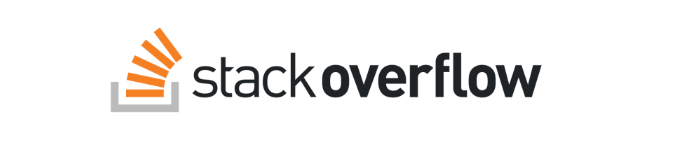

Le premier notebook contient le jeu de données des questions de Stacskoverflow
ou nous avons réalisé un nettoyage les données et les enregistrées 
sous le nom "Stack_questions_cleaned.csv". Nous l'exportons ici (dans ce présent Notebook) afin de réaliser des 
essais de différentes approches de modélisation supervisée et non-supervisée
des données textuelles
avant de choisir un modèle exploitable pour une prediction de tags liés aux questions.

Tous les Notebooks du projet et l'api seront versionnés dans un repositoire GitHub disponible à l'adresse:  https://github.com/Bounkass/Proj5ml_oc.git

## <font color="#ea1c60">Sommaire</font>  
[1.Chargement et preprossessing](#section_1)

[2. Entrainement avec des approches supervisées](#section_2)

[3. Comparaison des modèles supervisés](#section_3) 

[4. word2vec embeddings](#section_4)

[5. BERT Embeddings](#section_5)

[5.1 BERT hub Tensorflow](#section_51)

[5.2 -U sentence-transformers](#section_52)

[5.3 USE - Universal Sentence Encoder](#section_53)

[6. USE - Entrainement avec des approches non supervisées](#section_6)

[6.1 LDA Modèle](#section_61)

[6.2 NMF Modèle](#section_62)

In [3]:
#python libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

### <font id="section_1">1. Chargement et préprocessing

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#path = "/content/drive/MyDrive/"

In [6]:
data = pd.read_csv('Stack_questions_cleaned.csv',sep=';')

In [7]:
from ast import literal_eval
for col in ['Title', 'Body', 'Tags', 'text_comb']:
     data[col] = data[col].apply(literal_eval)

In [8]:
data.head()

,Title,Body,Tags,text_comb
0,"[bracket, print, array, comma]","[slash, program, original, output, letter, por...","[java, array, android]","[slash, program, original, output, letter, por..."
1,"[c, listing, directory]","[file, directory, cross, folder, c, scan, plat...","[file, c]","[cross, directory, file, folder, listing, c, s..."
2,"[return, datatables, wcf, net]","[close, datatables, behaviorcontracts, datatab...","[web, service, c#, net]","[close, datatables, behaviorcontracts, datatab..."
3,"[element, visible, error]","[error, tesstcase, list, syntaxerror, element,...",[javascript],"[error, tesstcase, list, syntaxerror, element,..."
4,"[plugins, load, net]","[winapi, provide, question, plugins, create, l...","[net, window]","[winapi, provide, question, plugins, create, l..."


Les modèles de prédiction à besoin des entrées numériques pour faire des prédictions. Nous utilisons les features de Tf-idf qui engendre une matrice creuse. Les entrées de cette matrice sont des fréquences des mots pondérées par l'ordre des mots dans le corpus.

Les variables cibles, colonne de Tags (pour les modèles supervisés), nous allons utiliser MultiLabelBinarizer Transformer de Scikit-Learn.

In [9]:
%%time
# Define X and y
X = data["text_comb"]
y = data["Tags"]

# Initialize the "CountVectorizer" TFIDF for text_comb
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.97,
                             min_df= 3,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)
vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X for Full_doc: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print(f"Shape of y:              {y_binarized.shape}")

Shape of X for Full_doc: (19491, 9087)
Shape of y:              (19491, 50)
CPU times: total: 4.48 s
Wall time: 4.48 s


In [10]:
# Create train and test split (25%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.25, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (14618, 9087)
X_test shape : (4873, 9087)
y_train shape : (14618, 50)
y_test shape : (4873, 50)


On considère des métriques pour comparer les modèles de classification avec  la méthode de probabilité:

- précision moyenne
- ROC-AUC moyenne

Puis calculer le seuil optimal pour la courbe ROC pour ce type de multti_labels avec probabilité

In [11]:
def metrics_report(model_name ,test_labels, y_score,fit_time, df): 
    """
    Compute metrics specific to multi-label
    classification problems with with ptobability 

    Parameters
    ----------------------------------------
    model_name : string
        Name of the  model
    df : DataFrame 
        DataFrame to accumulate result, if None : Create DataFrame.
    test_labels : array of true labels
    y_pred : array of predicted labels with ptobability
    fit_time: fit time of the model
    ----------------------------------------
    """   
    if(df is not None):
        df_sc = df
    else:
        df_sc = pd.DataFrame(index=["Av_precision(macro)","Av_precision(micro)","ROC_AUC(macro)",\
                                      "ROC_AUC(micro)","Fit_time"],columns=[model_name])
        
    scores = []
    scores.append(average_precision_score(test_labels, y_score,average='macro'))
    scores.append(average_precision_score(test_labels, y_score,average='micro'))
    scores.append(roc_auc_score(test_labels, y_score, multi_class="ovr" ,average='macro'))
    scores.append(roc_auc_score(test_labels, y_score, multi_class="ovr" ,average='micro'))
    scores.append(fit_time)
    df_sc[model_name] = scores
    
    return df_sc

La fonction suivante calcule le seuil des courbes ROC pour des classifications avec des proportions. 

In [12]:
def cut_off(test_labels,y_score):
  """
  Compute threshold for predicted a probability of multi-labels 

  Parameters
  ----------------------------------------
  test_labels : array of true labels
  y_score : array of predicted labels with probability
  ----------------------------------------
  """   
  n = y_score.shape[1]
  thresholds = np.zeros(n)
  # Compute fpr, tpr, thresholds and roc auc
  for j in range(n):
     # calculate roc curves
     fpr, tpr, ths = roc_curve(y_test[:,j], y_score[:,j])
     # calculate the statistic 
     dis = abs(1-fpr-tpr)
     # locate the index of the lower distance
     idx = np.argmin(dis)
     thresholds[j] = ths[idx]
  threshold = thresholds.max() 
  
  return threshold

### <font id="section_2">2. Entrainement avec des approches supervisées

Le modèle de régression logistique:

In [16]:
reg_logit_clf = OneVsRestClassifier(LogisticRegression())
time1 = time.time()
reg_logit_clf.fit(X_train, y_train)
#Prediction
reg_logit_pred = reg_logit_clf.predict_proba(X_test)
fit_time = np.round(time.time() - time1,1)
df_performance = metrics_report("reg_logit", y_test, reg_logit_pred, fit_time,df=None)
print(df_performance)

                     reg_logit
Av_precision(macro)   0.651701
Av_precision(micro)   0.708355
ROC_AUC(macro)        0.966094
ROC_AUC(micro)        0.968779
Fit_time             10.400000


In [14]:
#seuil de classification
cut_off(y_test,reg_logit_pred)

0.11612371272675745

In [ ]:
# Inverse transform
threshold = cut_off(y_test,reg_logit_pred)
reg_logit_preds = (reg_logit_pred>threshold)*1
y_pred_inversed = multilabel_binarizer.inverse_transform(reg_logit_preds)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_pred_inversed[0:4])
print("True:", y_test_inversed[0:4])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('c++', 'java'), ('c', 'iphone', 'objective', 'swift', 'xcode'), ('image',), ('c', 'image', 'objective')]
True: [('c++',), ('iphone', 'swift'), ('image',), ('swift',)]


Modèle de KNN:

In [ ]:
%%time
knn_clf = OneVsRestClassifier(KNeighborsClassifier())
time1 = time.time()
#fit model
knn_clf.fit(X_train, y_train)
#predict with proba
knn_preds = knn_clf.predict_proba(X_test)
fit_time = np.round(time.time() - time1,1)
df_performance = metrics_report("knn", y_test, knn_preds, fit_time, df=df_performance)
print(df_performance)

                     reg_logit         knn
Av_precision(macro)   0.651701    0.428949
Av_precision(micro)   0.708355    0.477009
ROC_AUC(macro)        0.966094    0.849232
ROC_AUC(micro)        0.968779    0.871506
Fit_time             10.400000  131.200000
CPU times: user 2min 11s, sys: 543 ms, total: 2min 12s
Wall time: 2min 11s


In [ ]:
# Inverse transform
threshold = cut_off(y_test,knn_preds)
y_pred_inversed = multilabel_binarizer.inverse_transform((knn_preds>threshold)*1)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_pred_inversed[0:4])
print("True:", y_test_inversed[0:4])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('c++', 'java'), ('cocoa', 'swift', 'touch', 'xcode'), ('image',), ('c', 'objective')]
True: [('c++',), ('iphone', 'swift'), ('image',), ('swift',)]


Modèle SVM avec un noyau linéaire: 

In [ ]:
%%time
clf_svm_lin = OneVsRestClassifier(SVC(kernel="linear",probability=True))
time1 = time.time()
#fit model
clf_svm_lin.fit(X_train, y_train)
svm_pred = clf_svm_lin.predict_proba(X_test)
fit_time = np.round(time.time() - time1,1)
df_performance = metrics_report("svm_linear", y_test, svm_pred, fit_time, df=df_performance)
print(df_performance)

                     reg_logit         knn   svm_linear
Av_precision(macro)   0.651701    0.428949     0.648814
Av_precision(micro)   0.708355    0.477009     0.720079
ROC_AUC(macro)        0.966094    0.849232     0.942065
ROC_AUC(micro)        0.968779    0.871506     0.956184
Fit_time             10.400000  131.200000  2270.000000
CPU times: user 37min 46s, sys: 4.42 s, total: 37min 51s
Wall time: 37min 50s


In [ ]:
threshold = cut_off(y_test, svm_pred)
print(threshold)

0.09070170949161104


In [ ]:
# Inverse transform
threshold = cut_off(y_test, svm_pred)
y_pred_inversed = multilabel_binarizer.inverse_transform((svm_pred>threshold)*1)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_pred_inversed[0:4])
print("True:", y_test_inversed[0:4])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('c++',), ('objective', 'swift'), ('image',), ('c', 'image', 'objective')]
True: [('c++',), ('iphone', 'swift'), ('image',), ('swift',)]


Modèle de Forêt aléatoire:

In [ ]:
%%time
rf_clf = OneVsRestClassifier(RandomForestClassifier())
time1 = time.time()
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict_proba(X_test)
fit_time = np.round(time.time() - time1,1)
df_performance = metrics_report("Random Forest", y_test, rf_preds,fit_time, df=df_performance)
print(df_performance)

                     reg_logit         knn   svm_linear  Random Forest
Av_precision(macro)   0.651701    0.428949     0.648814       0.624743
Av_precision(micro)   0.708355    0.477009     0.720079       0.697556
ROC_AUC(macro)        0.966094    0.849232     0.942065       0.948776
ROC_AUC(micro)        0.968779    0.871506     0.956184       0.958011
Fit_time             10.400000  131.200000  2270.000000     392.000000
CPU times: user 6min 15s, sys: 1.11 s, total: 6min 16s
Wall time: 6min 32s


In [ ]:
rfo_clf = OneVsRestClassifier(RandomForestClassifier(min_samples_split=4, n_estimators=500))
time1=time.time()
rfo_clf.fit(X_train, y_train)
rfo_preds = rfo_clf.predict_proba(X_test)
fit_time = np.round(time.time() - time1,1)
metrics_report("Random Forest", y_test, rfo_preds, fit_time, df = None)

,Random Forest
Av_precision(macro),0.643741
Av_precision(micro),0.713821
ROC_AUC(macro),0.956212
ROC_AUC(micro),0.963850
Fit_time,1680.500000


In [ ]:
threshold = cut_off(y_test, rf_preds)
print(threshold)

0.17


In [ ]:
# Inverse transform
threshold = cut_off(y_test,rf_preds)
y_pred_inversed = multilabel_binarizer.inverse_transform((rf_preds>threshold)*1)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_pred_inversed[0:4])
print("True:", y_test_inversed[0:4])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('c++', 'java'), ('c', 'objective', 'swift', 'xcode'), ('image',), ('c', 'objective')]
True: [('c++',), ('iphone', 'swift'), ('image',), ('swift',)]


Mpdèle de Gradient-boost:

In [ ]:
%%time
gb_clf = OneVsRestClassifier(GradientBoostingClassifier())
time1 = time.time()
gb_clf.fit(X_train, y_train)
gb_preds = gb_clf.predict_proba(X_test)
fit_time = np.round(time.time() - time1,1)
df_performance = metrics_report("GradientBoosting", y_test, gb_preds, fit_time, df=df_performance)
print(df_performance)

                     reg_logit         knn   svm_linear  Random Forest  \
Av_precision(macro)   0.651701    0.428949     0.648814       0.624743   
Av_precision(micro)   0.708355    0.477009     0.720079       0.697556   
ROC_AUC(macro)        0.966094    0.849232     0.942065       0.948776   
ROC_AUC(micro)        0.968779    0.871506     0.956184       0.958011   
Fit_time             10.400000  131.200000  2270.000000     392.000000   

                     GradientBoosting  
Av_precision(macro)          0.517832  
Av_precision(micro)          0.575087  
ROC_AUC(macro)               0.923806  
ROC_AUC(micro)               0.935905  
Fit_time                   716.000000  
CPU times: user 11min 44s, sys: 12.7 s, total: 11min 57s
Wall time: 11min 56s


In [ ]:
threshold = cut_off(y_test, gb_preds)
print(threshold)

0.06580256824268968


In [ ]:
# Inverse transform
threshold = cut_off(y_test, gb_preds)
y_pred_inversed = multilabel_binarizer.inverse_transform((gb_preds>threshold)*1)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_pred_inversed[0:4])
print("True:", y_test_inversed[0:4])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('c++', 'java', 'string'), ('c', 'c#', 'swift', 'xcode'), ('algorithm', 'android', 'image'), ('c', 'image', 'objective')]
True: [('c++',), ('iphone', 'swift'), ('image',), ('swift',)]


### <font id="section_3">3.Comparaison des Modèles supervisés

Le choix du modèle supervisé final se basera essentiellement  sur les scores obtenus aux métriques. Nous prendrons également en compte le nombre de prédiction vide est le temps de simulation.

In [ ]:
results_perf = df_performance.T
print(results_perf)

                  Av_precision(macro)  Av_precision(micro)  ROC_AUC(macro)  \
reg_logit                    0.651701             0.708355        0.966094   
knn                          0.428949             0.477009        0.849232   
svm_linear                   0.648814             0.720079        0.942065   
Random Forest                0.624743             0.697556        0.948776   
GradientBoosting             0.517832             0.575087        0.923806   

                  ROC_AUC(micro)  Fit_time  
reg_logit               0.968779      10.4  
knn                     0.871506     131.2  
svm_linear              0.956184    2270.0  
Random Forest           0.958011     392.0  
GradientBoosting        0.935905     716.0  


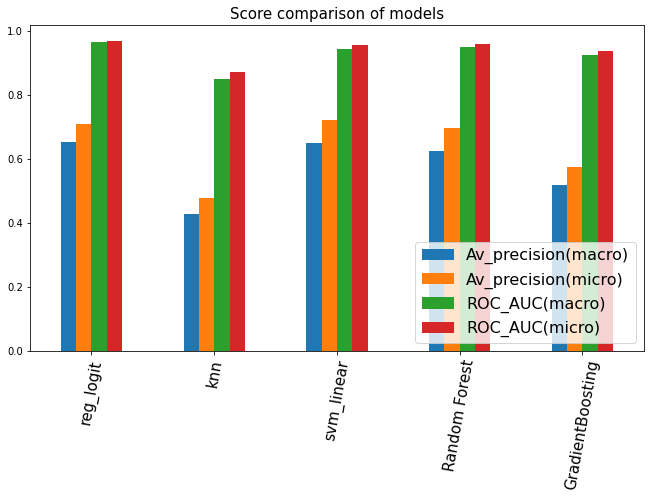

In [ ]:
col_model =['Av_precision(macro)', 'Av_precision(micro)', 'ROC_AUC(macro)','ROC_AUC(micro)']
ax = results_perf[col_model].plot.bar(figsize= (11,6));
ax.legend(loc=4,fontsize=16);
ax.set_xticklabels(results_perf.index,rotation=80, fontsize=15);
ax.set_title('Score comparison of models', fontsize=15);


Nous pouvons remarquer que le modèle de régression logistique offre des meilleures précisions en vue des métriques considérées. Le modèle de SVM offre aussi des meilleurs scores. Cependant son temps d'ajustement est très important. Le score de random forest peut être améliorer en augmentant le paramètre max_depth, n_estimators  ou min_samples_split. Cependant cela implique un temps de calcul important pour des scores proches de la régression linéaire.

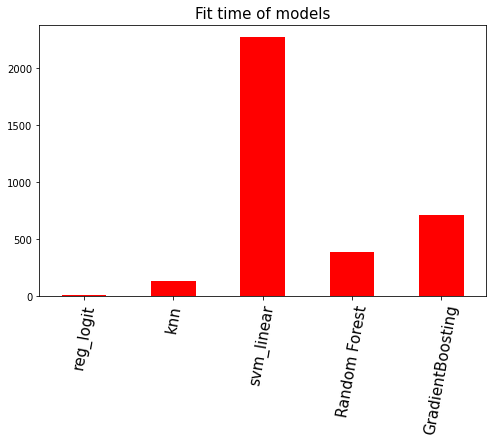

In [ ]:
ax = results_perf['Fit_time'].plot.bar(figsize= (8,5),color='red');
ax.set_xticklabels(results_perf.index,rotation=80, fontsize=15);
ax.set_title('Fit time of models', fontsize=15);

Nous  comparons le nombre de lignes dont les Tags ne sont pas prédit par les modèles:

In [ ]:
th_lr = cut_off(y_test,reg_logit_pred)
count_lr = sum(((reg_logit_pred>th_lr)*1).T)
th_rf = cut_off(y_test,rf_preds)
count_rf= sum(((rf_preds>th_rf)*1).T)
th_svm = cut_off(y_test,svm_pred)
count_svm= sum(((svm_pred>th_rf)*1).T)
print('le nombre de prédiction vide par la Regression Logistic est: ', sum(count_lr==0))
print('le nombre de prédiction vide par le Random Forest est:       ', sum(count_rf==0))
print('le nombre de prédiction vide par le SVM:                     ', sum(count_svm==0))

le nombre de prédiction vide par la Regression Logistic est:  89
le nombre de prédiction vide par le Random Forest est:        192
le nombre de prédiction vide par le SVM:                      185


### <font id="section_4">4. word2vec embeddings

Word2vec, comme doc2vec, permet de transformer uu groupe de mots par un ensemble de vecteurs denses. Word2vec est un type de mappage qui permet à des mots ayant une signification similaire d'avoir une représentation vectorielle similaire.

Nous utilisons les features d'un modèle pré-entrainé de gensim combiné avec la régression linéaire

In [ ]:
from gensim.models import word2vec
#
model_w2v = word2vec.Word2Vec(data.text_comb, size=164, window=15, min_count=3, workers=7)
model_w2v.corpus_count

19491

In [ ]:
vocab = model_w2v.wv.vocab
list(vocab)[:6]

['slash', 'program', 'original', 'output', 'letter', 'port']

Regardons les tokens les plus similaires au mot "python":

In [ ]:
model_w2v.wv.most_similar(['python'])

[('ipython', 0.8268296718597412),
 ('print', 0.8149738311767578),
 ('variable', 0.8042786121368408),
 ('utf', 0.8016868829727173),
 ('binary', 0.8005759119987488),
 ('vba', 0.7923832535743713),
 ('indexerror', 0.7877026796340942),
 ('scipy', 0.7862895727157593),
 ('gensim', 0.7779965400695801),
 ('plot', 0.7752940058708191)]

Nous construisons les features par addition des vecteurs des mots dans le vocabulaire de word2vect

In [ ]:
def document_vector(doc):
    """Create document vectors by summing word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in model_w2v.wv.vocab]
    return np.sum(model_w2v.wv[doc], axis=0)

In [ ]:
%%time
# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(data.text_comb, y_binarized, test_size=0.2, random_state=42)
#
wv_train_feat = X_train.apply(document_vector)
wv_test_feat = X_test.apply(document_vector)
#
clf_lr = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
clf_lr.fit(list(wv_train_feat), y_train)
lr_pred = clf_lr.predict_proba(list(wv_test_feat))

CPU times: user 7min 2s, sys: 1min 8s, total: 8min 11s
Wall time: 4min 15s


In [ ]:
df_perf_wv = metrics_report("reg_logit_wv", y_test, lr_pred,255, df=None)
print(df_perf_wv)

                     reg_logit_wv
Av_precision(macro)      0.504189
Av_precision(micro)      0.616867
ROC_AUC(macro)           0.938493
ROC_AUC(micro)           0.950487
Fit_time               255.000000


Le score de la précision moyenne de la régression logistique est nettement moins que le score obtenu avec la matrice Tf-idf . Nous allons essayer de l'améliorer en jouant avec les hyperparamètres de l'apprentissage.

 ou réutiliser un model pré-entrainé significativement large et impliquant un corpus similaire à notre jeu de données.

In [ ]:
# paramètres à varier size et windiw
size = [64, 128, 256, 400]
W =[5, 10, 15, 20]
sc1 = []
sc2 = []
score1 = {}
score2 = {}
for w in W:
  for s in size: 
     model_w2v = word2vec.Word2Vec(data.text_comb, size=s, window=w, min_count=3, workers=7)
     wv_train_feat, wv_test_feat, y_train, y_test = train_test_split(data.text_comb.apply(document_vector), y_binarized, test_size=0.2, random_state=42)
     clf_lr = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
     clf_lr.fit(list(wv_train_feat), y_train)
     lr_pred = clf_lr.predict_proba(list(wv_test_feat))
     sc1.append(average_precision_score(y_test, lr_pred,average='macro'))
     sc2.append(roc_auc_score(y_test, lr_pred, multi_class="ovr" ,average='macro'))
  score1[w] = sc1
  score2[w] = sc2
  sc1=[] 
  sc2=[] 


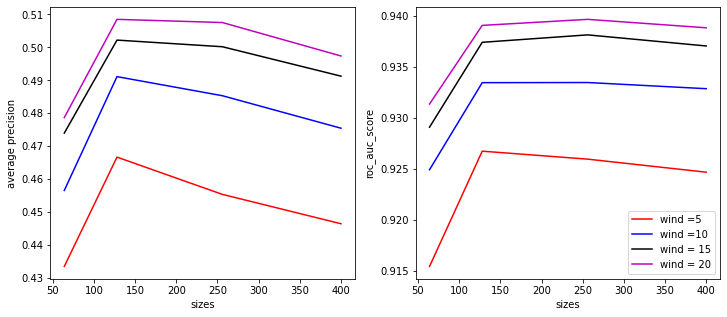

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(size, score1[5], c='r')
ax1.plot(size, score1[10], c='b')
ax1.plot(size, score1[15], c='k')
ax1.plot(size, score1[20], c='m')
ax1.set_xlabel('sizes')
ax1.set_ylabel('average precision')
ax2.legend(labels = ['wind =5','wind =10','wind = 15','wind = 20'])
ax2.plot(size, score2[5], c='r')
ax2.plot(size, score2[10], c='b')
ax2.plot(size, score2[15], c='k')
ax2.plot(size, score2[20], c='m')
ax2.set_xlabel('sizes')
ax2.set_ylabel('roc_auc_score')
ax2.legend(labels = ['wind =5','wind =10','wind = 15','wind = 20']);

Nous remarquons que le paramètre de fenêtre "window" améliore nettement la précision. Cependant, le paramètre 'size' (la longeur des vecteurs des mots) à partir d'un plateau, la précision stagne voir décroît. 

In [ ]:
time1 = time.time()
model_w2v = word2vec.Word2Vec(data.text_comb, size=264, window=20, min_count=3, workers=7, sg=1)
wv_train_feat, wv_test_feat, y_train, y_test = train_test_split(data.text_comb.apply(document_vector), y_binarized, test_size=0.2, random_state=42)
clf_lr = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
clf_lr.fit(list(wv_train_feat), y_train)
lr_pred = clf_lr.predict_proba(list(wv_test_feat))
fit_time = np.round(time.time() - time1,1)

In [ ]:
dt = pd.DataFrame(df_performance.reg_logit).rename({'reg_logit':'reg_logit_tfidf'},axis='columns')
df_perf_wv = metrics_report("reg_logit_wv", y_test, lr_pred, fit_time, df=dt)
print(df_perf_wv)

                     reg_logit_tfidf  reg_logit_wv
Av_precision(macro)         0.651701      0.588561
Av_precision(micro)         0.708355      0.689829
ROC_AUC(macro)              0.966094      0.950093
ROC_AUC(micro)              0.968779      0.961318
Fit_time                   10.400000    351.300000


### <font id="section_5">5. BERT Embeddings

BERT abréviation de Bi-directional Encoder Representations from Transformers.
La famille de modèles BERT utilise l'architecture de l'encodeur Transformer pour traiter chaque jeton de texte d'entrée dans le contexte complet de tous les jetons avant et après, d'où le nom : Représentations d'encodeur bidirectionnel de Transformers.

Les modèles BERT sont généralement pré-formés sur un grand corpus de texte, puis affinés pour des tâches spécifiques.

#### <font id="section_51"> 5.1 BERT hub Tensorflow

Installation des transformeurs et tensorflow-text pour bert. Nous utilisons un GPU comme le calcul des features demande un effort important.

In [ ]:
!pip install transformers

In [ ]:
!pip install tensorflow_text

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

In [13]:
dt =data.copy()
dt.text_comb = dt.text_comb.apply(lambda text : " ".join(text))

In [14]:
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2" 
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [15]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)

pour de raison de mémoire, la fonction suivante construit la matrice des features de Bert morceau par morceau 

In [16]:
def feature_bert_tfh(sentences, key, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        inputs = preprocess(sentences[idx:idx+batch_size])
        feat = bert(inputs)[key]

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    if idx+batch_size<len(sentences):
       inputs = preprocess(sentences[idx+batch_size:len(sentences)])
       feat = bert(inputs)[key]
       features = np.concatenate((features,feat))      

    return features

Régression logistique combinée avec les features de Bert

In [25]:
reg_logit_clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
time1=time.time()
feat_bert = feature_bert_tfh(dt.text_comb, 'pooled_output',128)
# split features
Bertfet_train, Bertfet_test, y_train, y_test = train_test_split(feat_bert, y_binarized, test_size=0.25)
reg_logit_clf.fit(Bertfet_train, y_train)
#Prediction
bert_plr = reg_logit_clf.predict_proba(Bertfet_test)
fit_time = np.round(time.time() - time1,1)
df_perf_brt_tfh = metrics_report("reg_log_bert_tfhub", y_test, bert_plr,fit_time, df=df)
print(df_perf_brt_tfh)

,reg_logit_tfidf,reg_logit_wv,reg_log_bert_tfhub
Av_precision(macro),0.651701,0.588561,0.366203
Av_precision(micro),0.708355,0.689829,0.430634
ROC_AUC(macro),0.966094,0.950093,0.872900
ROC_AUC(micro),0.968779,0.961318,0.891715
Fit_time,10.400000,351.300000,628.400000


Le score de la régression logistique avec Bert est nettement moins bon  que le score obtenu avec la matrice Tf-idf. Il faut réutiliser un autre model pré-entrainé significativement large et impliquant un corpus similaire à notre jeu de données.

#### <font id="section_52"> 5.2 -U sentence-transformers

SentenceTransformer('all-MiniLM-L6-v2') Il s'agit d'un modèle de transformation de phrases qui représente les phrases avec des vecteurs denses de 384 dimensions.

In [ ]:
# install -U sentence-transformers
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
#download a pretrained model
model_bert = SentenceTransformer('all-MiniLM-L6-v2')
#model_bert = SentenceTransformer('all-mpnet-base-v2')

pour de raison de mémoire, la fonction suivante construit la matrice des features de Bert morceau par morceau 

In [28]:
def feature_bert_ST(sentences, b_size) :
    batch_size = b_size
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = model_bert.encode(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

     
    if idx+batch_size<len(sentences):
    
       features = np.concatenate(features,model_bert.encode(sentences[idx+batch_size:len(sentences)]))

    return features

Régression logistique combinée avec les features de Bert 'all-MiniLM-L6-v2'.

In [38]:
%%time
batch_size = 64
sentence_embeddings = model_bert.encode(dt.text_comb)
# split features
time1 = time.time()
Bertfet_train, Bertfet_test, y_train, y_test = train_test_split(sentence_embeddings, y_binarized, test_size=0.25)
reg_logit_clf = OneVsRestClassifier(LogisticRegression())
reg_logit_clf.fit(Bertfet_train, y_train)
#Prediction
bert_pred_lr = reg_logit_clf.predict_proba(Bertfet_test)

fit_time = np.round(time.time() - time1,1)
df_perf_brt_ST = metrics_report("df_perf_brt_ST", y_test, bert_pred_lr, fit_time, df=df_perf_brt_tfh)
print(df_perf_brt_ST)

                     reg_logit_tfidf  reg_logit_wv  reg_log_bert_tfhub  \
Av_precision(macro)         0.651701      0.588561            0.366203   
Av_precision(micro)         0.708355      0.689829            0.430634   
ROC_AUC(macro)              0.966094      0.950093            0.872900   
ROC_AUC(micro)              0.968779      0.961318            0.891715   
Fit_time                   10.400000    351.300000          628.400000   

                     df_perf_brt_ST  
Av_precision(macro)        0.637932  
Av_precision(micro)        0.724792  
ROC_AUC(macro)             0.964328  
ROC_AUC(micro)             0.971773  
Fit_time                  16.800000  
CPU times: user 40 s, sys: 5.83 s, total: 45.8 s
Wall time: 28.1 s


#### <font id="section_53"> 5.3 USE - Universal Sentence Encoder

Le score de la régression logistique avec Bert est nettement moins bon  que le score obtenu avec la matrice Tf-idf. Il faut réutiliser un autre model pré-entrainé significativement large et impliquant un corpus similaire à notre jeu de données.

In [39]:
#First download a pretrained model
Model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [40]:
def feature_USE(sentences, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = Model_use(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

     
    if idx+batch_size<len(sentences):
       feat = Model_use(sentences[idx+batch_size:len(sentences)])
       features = np.concatenate((features,feat))

    return features

In [41]:
%%time
time1 = time.time()
batch_size = 64
use_features = feature_USE(dt.text_comb, batch_size)
# split features
usefet_train, usefet_test, y_train, y_test = train_test_split(use_features, y_binarized, test_size=0.25)
reg_logit_clf = OneVsRestClassifier(LogisticRegression())
reg_logit_clf.fit(usefet_train, y_train)
#Prediction
usepred_lr = reg_logit_clf.predict_proba(usefet_test)

fit_time = np.round(time.time() - time1,1)
df_perf_use = metrics_report("reg_logit with use", y_test, usepred_lr, fit_time, df=df_perf_brt_ST)
print(df_perf_use)

                     reg_logit_tfidf  reg_logit_wv  reg_log_bert_tfhub  \
Av_precision(macro)         0.651701      0.588561            0.366203   
Av_precision(micro)         0.708355      0.689829            0.430634   
ROC_AUC(macro)              0.966094      0.950093            0.872900   
ROC_AUC(micro)              0.968779      0.961318            0.891715   
Fit_time                   10.400000    351.300000          628.400000   

                     df_perf_brt_ST  reg_logit with use  
Av_precision(macro)        0.637932            0.631853  
Av_precision(micro)        0.724792            0.730458  
ROC_AUC(macro)             0.964328            0.965771  
ROC_AUC(micro)             0.971773            0.973241  
Fit_time                  16.800000           33.600000  
CPU times: user 51.4 s, sys: 7.94 s, total: 59.3 s
Wall time: 34 s


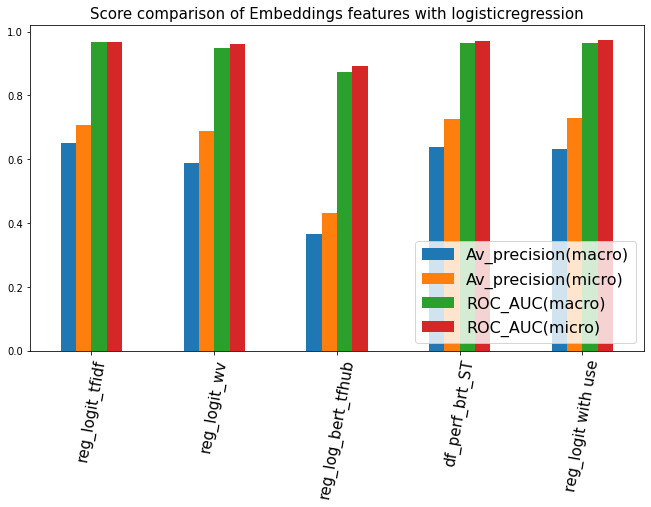

In [48]:
df_result = df_perf_use.T
col_model =['Av_precision(macro)', 'Av_precision(micro)', 'ROC_AUC(macro)','ROC_AUC(micro)']
ax = df_result[col_model].plot.bar(figsize= (11,6));
ax.legend(loc=4,fontsize=16);
ax.set_xticklabels(df_result.index,rotation=80, fontsize=15);
ax.set_title('Score comparison of Embeddings features with logisticregression', fontsize=15);

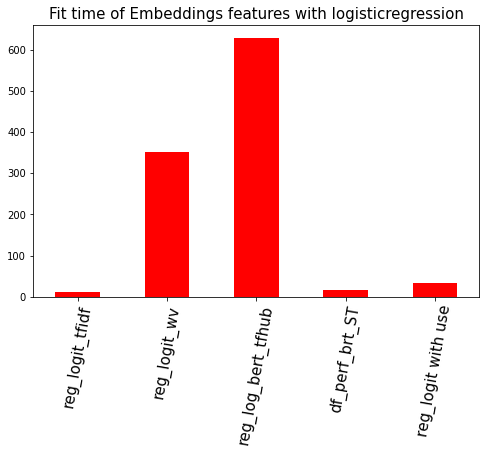

In [47]:
ax = df_result['Fit_time'].plot.bar(figsize= (8,5),color='red');
ax.set_xticklabels(df_result.index,rotation=80, fontsize=15);
ax.set_title('Fit time of Embeddings features with logisticregression', fontsize=15);

Le score de la régression logistique avec U sentence-transformers et USE
est nettement proche supérieurement du score obtenu avec la matrice Tf-idf. Cependant même avec GPU le temps de calcul est beaucoup important en comparaison avec la matrice Tf-idf.

### <font id="section_6"> 6. Entrainement avec des approches non supervisées

#### <font id="section_61"> 6.1 LAD modèle

Latent Dirichlet Allocation (LDA) est une technique de clustering non supervisée utilisée pour l'analyse de texte. Le nombre de sujets peut être vu comme le nombre de clusters. En faisant de la modélisation thématique, nous construisons des groupes de mots plutôt que des groupes de textes. Un texte est donc un mélange de tous les topics, chacun ayant un poids spécifique.
 
Le module *"LdaMulticore de Gensim"*  permet d'une parallélisation, on choisit celui qui possède un score de cohérence maximum suivant le nombre de topic. Le score de coherence mesure le degré de similitude sémantique des mots les plus représentés pour chaque topic.

In [49]:
import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
from pprint import pprint
from gensim.models import CoherenceModel
# Create Dictionary
id2word = corpora.Dictionary(data.text_comb)
# Create Corpus
Texts = data.text_comb
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in Texts]
# View
print(corpus[:1])
count = 0
for tk in id2word.values():
    print(tk)
    count += 1
    if count > 10:
        break

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]]
android
array
beautify
bit
bracket
class
code
comma
console
correct
fit


Exemple de réalisation du modèle LDA avec 10 topics:

In [ ]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, passes=2, iterations=25)

In [ ]:
# Print the Keyword in 5 topics
pprint(lda_model.print_topics(5))
doc_lda = lda_model[corpus]

[(7,
  '0.026*"database" + 0.015*"table" + 0.012*"data" + 0.011*"sql" + '
  '0.010*"store" + 0.009*"create" + 0.009*"mysql" + 0.009*"query" + '
  '0.009*"server" + 0.008*"code"'),
 (9,
  '0.026*"android" + 0.018*"app" + 0.012*"api" + 0.009*"user" + '
  '0.008*"application" + 0.008*"code" + 0.007*"device" + 0.006*"service" + '
  '0.006*"access" + 0.006*"client"'),
 (6,
  '0.013*"spring" + 0.011*"data" + 0.010*"view" + 0.010*"json" + 0.009*"mvc" + '
  '0.009*"asp" + 0.009*"request" + 0.009*"create" + 0.008*"controller" + '
  '0.008*"code"'),
 (2,
  '0.010*"java" + 0.009*"question" + 0.008*"difference" + 0.007*"class" + '
  '0.007*"method" + 0.006*"performance" + 0.006*"type" + 0.006*"implement" + '
  '0.006*"implementation" + 0.006*"code"'),
 (1,
  '0.009*"window" + 0.008*"file" + 0.008*"code" + 0.007*"error" + 0.007*"add" '
  '+ 0.006*"follow" + 0.006*"create" + 0.005*"application" + 0.005*"solution" '
  '+ 0.005*"event"')]


In [ ]:
#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=Texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', round(coherence_lda,4))


Coherence Score:  0.5352


Nous allons utiliser le score de la cohérence pour le modèle LDA afin de choisir les hyperparmètres qui maximisent cette score. Nous considérons les paramètres suivants:

- Nombre de topic: K

- Hyperparamètre de Dirichlet α : paramètre de densité document-topic

- Hyperparamètre de Dirichlet η : paramètre de densité de mots-topic

In [ ]:
topics_nb = range(10,31)
# Alpha parameter
alpha = ['symmetric', 'asymmetric']
# Eta parameter
eta = ['symmetric', 'auto']
CS={}
cs={}
csn=[]
for a in alpha:
   for e in eta:
     for k in topics_nb:
        lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, random_state=42,
                                 passes=10, alpha=a, eta=e,workers=7)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=Texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
        csn.append(coherence_model_lda.get_coherence())
     cs[e] = csn
     csn=[]
   CS[a] = cs 
   cs={}

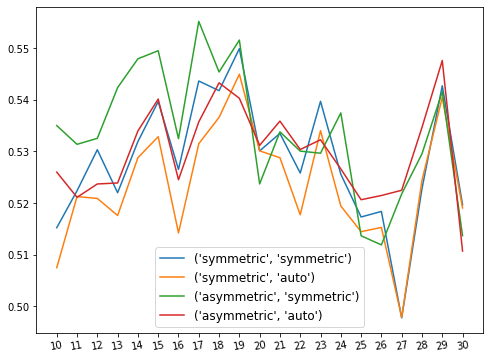

In [ ]:
fig = plt.figure(figsize=(8, 6))
topics_nb = range(10,31)
leg=[]
for k0 in CS.keys():
  for k1 in CS[k0].keys():
     plt.plot(topics_nb,CS[k0][k1])
     leg.append((k0, k1))
plt.xticks(topics_nb, topics_nb,rotation=10)
plt.legend(leg,fontsize=12);

In [ ]:
#find parameters in which the coherence is the highest
opt={}
for a in alpha:
  opt[a]=max(CS[a])
K = list(opt.keys())
if max(CS[K[0]][opt[K[0]]]) < max(CS[K[1]][opt[K[1]]]):
  alpha_opt = K[1]
  eta_opt = opt[K[1]]
else:
  alpha_opt = K[0]
  eta_opt = opt[K[0]]

nb_opt = topics_nb[np.argmax(CS['asymmetric']['symmetric'])]
CS_opt = max(CS['asymmetric']['symmetric'])
print(f"We get the highest coherence score {CS_opt}, when:\n alpha = '{alpha_opt}', eta = '{eta_opt}' and number of topics equals {nb_opt}.")  


We get the highest coherence score 0.5551661808395734, when:
 alpha = 'asymmetric', eta = 'symmetric' and number of topics equals 17


Maintenant, nous considérons, le nombre de topics optimal nb_opt=17, puis nous
allons analyser la coherence suivant les deux paramètres alpha et eta.

In [ ]:
topics_nb = 17
# Alpha parameter
alpha = [0.01, 0.3, 0.9,'symmetric', 'asymmetric']
# Eta parameter
eta = [0.01, 0.3, 0.9,'symmetric', 'auto']
CS={}
cs=[]
for a in alpha:
   for e in eta:
     lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=topics_nb, random_state=42,
                                 passes=10, alpha=a, eta=e, workers=7)
     coherence_model_lda = CoherenceModel(model=lda_model, texts=Texts, 
                                     dictionary=id2word, coherence='c_v')
     cs.append(coherence_model_lda.get_coherence())
   CS[a] = cs
   cs=[] 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


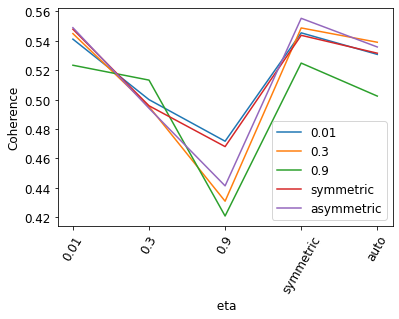

In [ ]:
fig = plt.figure()
x=range(len(eta))
for key in CS.keys():
  plt.plot(CS[key])
plt.xticks(x, eta,fontsize=12,rotation=60)
plt.yticks(fontsize=12)
plt.ylabel('Coherence',fontsize=12)
plt.xlabel(' eta',fontsize=12)
plt.legend(labels=alpha,fontsize=12)
plt.show()

In [ ]:
max_0=[]
for k in range(0,len(CS.keys())):
   max_0.append(max(CS[alpha[k]]))

max_key = alpha[np.argmax(max_0)]
max_val = eta[np.argmax(CS[max_key])]

print(f'With ten topics, the coherence score is highest when alpha = {max_key} and eta = {max_val}')

With ten topics, the coherence score is highest when alpha = asymmetric and eta = symmetric


On visualise les résultats à l'aide du package pyLDAvis. les sujets sont représentés avec des cercles dont la taille est liée à la popularité du sujet.
Un bon modèle de sujet aura de grands cercles non superposés dispersés dans tout le graphique

Sur le côté droit, les mots-clés les plus pertinents du sujet sélectionné.

In [ ]:
pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# train the model with optimal parameters
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=nb_opt, random_state=42,
                                passes=10, alpha=alpha_opt, eta=eta_opt)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds',R=20)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.217563  0.001431       1        1  11.388102
0      0.012170  0.097597       2        1  10.308232
4      0.273228 -0.121156       3        1   9.887811
10    -0.045191  0.194857       4        1   9.590893
2      0.225912  0.146116       5        1   8.536407
1     -0.078022 -0.068451       6        1   7.629048
9      0.065722 -0.097957       7        1   7.377199
11     0.253496 -0.247426       8        1   5.843567
5     -0.071780  0.320553       9        1   5.381102
8      0.370976  0.102546      10        1   4.654164
12     0.106956  0.321634      11        1   4.590644
14    -0.236140  0.235587      12        1   3.914153
7     -0.250245 -0.062920      13        1   3.093042
3      0.058014 -0.349757      14        1   2.991446
16    -0.096366 -0.329185      15        1   2.730184
13    -0.366032 -0.228130      16        1   1.072606
15    -0.440261  0.084660      17        1   1.011399, topic_info=         Term         Freq        Total Category  logprob  loglift
33       file  4896.000000  4896.000000  Default  20.0000  20.0000
101     image  1912.000000  1912.000000  Default  19.0000  19.0000
363    python  2434.000000  2434.000000  Default  18.0000  18.0000
447    string  1925.000000  1925.000000  Default  17.0000  17.0000
309    spring   984.000000   984.000000  Default  16.0000  16.0000
...       ...          ...          ...      ...      ...      ...
429    public    62.759504   235.222050  Topic17  -4.6413   3.2726
2587  restore    30.050910    69.804628  Topic17  -5.3777   3.7510
8325  openssl    30.146047    78.030638  Topic17  -5.3745   3.6428
254      time    68.509697  2900.430849  Topic17  -4.5536   0.8482
2966    plist    25.935503    80.498084  Topic17  -5.5249   3.4612

[826 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4914     13  0.986183      aar
256       1  0.438141   access
256       2  0.139678   access
256       3  0.013836   access
256       4  0.004612   access
...     ...       ...      ...
312      15  0.216065      xml
312      17  0.020653      xml
1144      1  0.025662  youtube
1144      5  0.966596  youtube
4764      2  0.984851   zipped

[2490 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 5, 11, 3, 2, 10, 12, 6, 9, 13, 15, 8, 4, 17, 14, 16])

##### Distribution des thèmes pour chaque documents

In [96]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=17, random_state=42,
                                passes=10, alpha='asymmetric', eta='symmetric')

In [114]:
# obtain topic distributions for each document
topic_dist = pd.DataFrame(lda_model.get_document_topics(corpus, minimum_probability=0.0))
for topic in topic_dist.columns:
    topic_dist[topic] = topic_dist[topic].apply(lambda x : x[1])

print('matrix of document/topic distribution shape:', topic_dist.shape)

matrix of document/topic distribution shape: (19491, 17)


In [98]:
topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.216395,0.454984,0.003036,0.161126,0.002287,0.002037,0.001836,0.001671,0.001533,0.001416,0.001316,0.001229,0.001152,0.147063,0.001025,0.000972,0.000923
1,0.518139,0.012501,0.010454,0.008985,0.394143,0.007015,0.006322,0.005754,0.005279,0.004877,0.004532,0.004232,0.003970,0.003738,0.003532,0.003347,0.003181
2,0.003507,0.130492,0.002352,0.238370,0.001773,0.157372,0.001423,0.001295,0.001188,0.312673,0.031459,0.000952,0.000893,0.000841,0.113942,0.000753,0.000716
3,0.006086,0.381666,0.004090,0.003516,0.110507,0.002745,0.002474,0.002252,0.002066,0.124292,0.307166,0.001656,0.001553,0.001463,0.001382,0.001310,0.045776
4,0.286922,0.005625,0.004704,0.004043,0.486239,0.003157,0.002845,0.189956,0.002376,0.002195,0.002039,0.001904,0.001786,0.001682,0.001589,0.001506,0.001431


Pour attribuer des predictions du modèle LDA des Tags à chaque question, nous allons utiliser deux approches. La première approche se base sur le calcul de la matric de scores de Topics/Tags. La deuxième approche consiste à passer la matrice des Documents/Tags comme des features dans un modèle de régression logistique.

Nous allons utiliser des distributions des thèmes obtenus par le modèle LDA comme des features pour le modèle d'une régression logistique. Dans le bus de caractériser la qualité de ces features ainsi la performance du modèle LDA.

In [99]:
#split data
time1 =time.time()
x_train, x_test, y_train, y_test = train_test_split(topic_dist, y_binarized, test_size=0.25, random_state=100)
lr = OneVsRestClassifier(LogisticRegression()).fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_test)
fit_time = np.round(time.time() - time1,1)
#score of prediction
df_LDA_lr = metrics_report("LDA_lr", y_test, y_pred_lr,fit_time, df=None)
print(df_LDA_lr)

                       LDA_lr
Av_precision(macro)  0.182246
Av_precision(micro)  0.252294
ROC_AUC(macro)       0.844211
ROC_AUC(micro)       0.866935
Fit_time             7.000000


Nous allons construire la matrice topics/tags des scores des tags, elle est obtenue en faisant le produit matricielle de la matrice des distributions des topicset le vecteur des tags.

In [136]:
topic_tag = np.matmul(topic_dist.T, y_binarized)
# normalizing 
topic_tag = topic_tag/np.sum(y_binarized,axis=0)

In [137]:
topic_tag.head(3)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.128682,0.069742,0.049993,0.162818,0.054312,0.290504,0.143000,0.457608,0.089989,0.093337,...,0.035174,0.073013,0.127948,0.111735,0.079153,0.070764,0.155300,0.056524,0.199653,0.078701
1,0.096367,0.053450,0.085711,0.307414,0.087008,0.073641,0.102542,0.052399,0.106214,0.071200,...,0.056724,0.176703,0.410824,0.036336,0.089246,0.086809,0.039858,0.071809,0.051084,0.042326
2,0.291931,0.096562,0.050193,0.081494,0.028274,0.124660,0.052230,0.065082,0.182549,0.111117,...,0.022504,0.039118,0.053883,0.026765,0.139998,0.202221,0.028842,0.039665,0.056727,0.087898


In [138]:
# Select predicted tags in Topics / Tags matrix
threshold = 0.3
y_result = pd.DataFrame(data['Tags'])
y_result["best_topic"] = topic_dist.idxmax(axis=1).values
list_tag = []
for tag in y_result.best_topic:
    tags_sort = topic_tag.iloc[tag].sort_values(ascending=False)
    nb_th = np.sum(tags_sort>threshold)
    row_tags = list(tags_sort[0:nb_th].index)
    list_tag.append(row_tags)
y_result["y_pred"] = list_tag
# Create a multibinarized of LDA prediction
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_result.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1

# inverse transformation
y_result["y_pred"] = multilabel_binarizer.inverse_transform(lda_y_pred)

In [139]:
y_result.head()

,Tags,best_topic,y_pred
0,"[java, array, android]",1,"(array, json, string)"
1,"[file, c]",0,"(c++, linux, memory, multithreading)"
2,"[web, service, c#, net]",9,"(database, mysql, server, sql)"
3,[javascript],1,"(array, json, string)"
4,"[net, window]",4,"(git, macos, studio, visual)"


In [140]:
from sklearn.metrics import precision_score
scores = {}
scores['precision(macro)']=precision_score(y_binarized,lda_y_pred,average='macro', zero_division=0)
scores['precision(micro)']=precision_score(y_binarized,lda_y_pred,average='micro', zero_division=0)
scores['ROC_AUC(macro)'] = roc_auc_score(y_binarized,lda_y_pred,average='macro')
scores['ROC_AUC(micro)']  = roc_auc_score(y_binarized,lda_y_pred,average='micro')

In [141]:
scores

{'precision(macro)': 0.0512943301418224,
 'precision(micro)': 0.133570069752695,
 'ROC_AUC(macro)': 0.5780310468464913,
 'ROC_AUC(micro)': 0.5482917901379916}

On remarque  que la modélisation non supervisée avec LDA n'est pas adaptée. En effet, avec cette dernière méthode de prédiction, un certain nombre de topics sont très regroupés affectant la prédiction des tags.

#### <font id="section_62"> 6.2 NMF Modèle

Le modèle NMF est autre version du modèle LDA, son score ne peut pas être quantifié. Nous allons donc utiliser comme dans le cas du  LDA n_components=17.

In [113]:
from sklearn.decomposition import NMF
# Create an NMF  model

model_nmf = NMF(n_components= 17, init='random', random_state=5, max_iter=500)
 
# Fit the model to TF-IDF
model_nmf.fit(X_tfidf)
 
# Transform the TF-IDF: nmf_features
nmf_features = model_nmf.transform(X_tfidf)

In [ ]:
print(X_tfidf.shape)
print(nmf_features.shape)
print(model_nmf.components_.shape)

(19117, 6616)
(19117, 17)
(17, 6616)


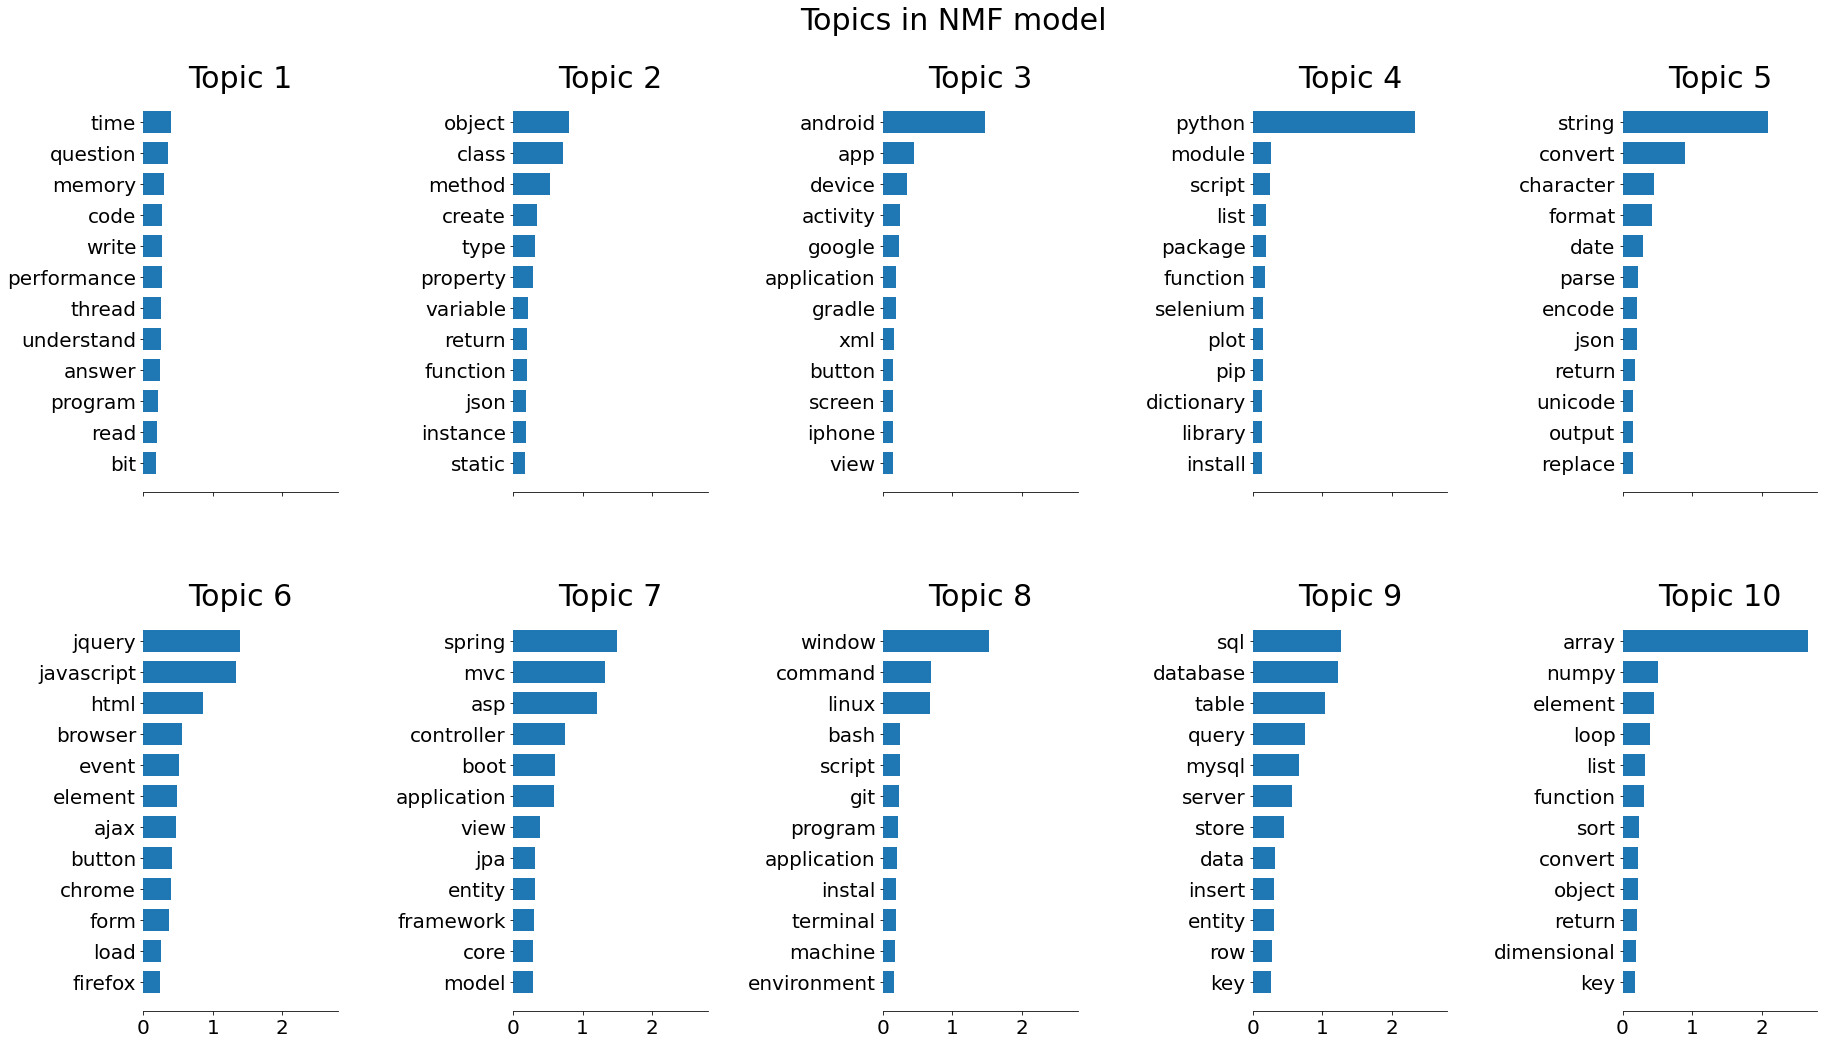

In [ ]:
# Plot the 10 first topics
n_top_words =12
feature_names = vectorizer.get_feature_names()
fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(model_nmf.components_):
  if(topic_idx < 10):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Topics in NMF model', fontsize=30)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.show()